<a href="https://colab.research.google.com/github/ahmedabassi/p2m-news/blob/main/Suleyman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EDA

In [1]:
from google.colab import drive
drive.mount('/content/drive') #amidou1133

Mounted at /content/drive


In [1]:
!ls

drive  sample_data


In [2]:
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/BankChurners.csv")

In [3]:
df.head(1)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991


In [4]:
df.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

Last two columns are irrelevant so let's delete them

In [5]:
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],inplace=True)

In [6]:
len(df.columns)

21

let's check for null values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

as we can see we have 6 objects so they must be our categorical values

In [8]:
for e in df.columns:
  if df[e].dtype=='O':
    print(e, df[e].unique())

Attrition_Flag ['Existing Customer' 'Attrited Customer']
Gender ['M' 'F']
Education_Level ['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status ['Married' 'Single' 'Unknown' 'Divorced']
Income_Category ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
Card_Category ['Blue' 'Gold' 'Silver' 'Platinum']


#Naive Bayes

In [9]:
df.drop(columns = ["CLIENTNUM"] , inplace = True)

##Estimating categorical 

In [10]:
def count_class(df):
  #class 1
  s=0
  for e in df.Attrition_Flag:
    if e == "Existing Customer":
      s+=1
  return [s,df.shape[0]-s]

In [11]:
count_class(df)

[8500, 1627]

In [12]:
def prior(df):
  return [e/df.shape[0] for e in count_class(df)]

In [13]:
prior(df)

[0.8393403772094401, 0.1606596227905599]

In [14]:
import numpy as np 
def estimate_categorical(df,col,alpha,N):
  #N = df.shape[1]-1
  s = list(col.unique())
  removed_attrib=s.pop()  #we can deduce the last element's probabilty by using P(A bar) = 1 - P(A)
  count_class1 = count_class(df)[0]
  count_class0 = count_class(df)[1]
  res = dict()
  sum_1=0
  sum_0=0
  for e in s:
    counter_1=0
    counter_0=0
    for i in range(df.shape[1]):
      #class 1 
      if (col[i]==e) and (df.Attrition_Flag[i] == "Existing Customer") : 
        counter_1+=1
      #class 0
      elif (col[i]==e) and (df.Attrition_Flag[i] == "Attrited Customer") : 
        counter_0+=1
    proba_1 = (counter_1 + alpha)/(count_class1 + alpha * N)
    proba_0 = (counter_0 + alpha)/(count_class0 + alpha * N)
    sum_1+=proba_1
    sum_0+=proba_0

    res[e] = [proba_1,proba_0]
  res[removed_attrib] = [1-sum_1,1-sum_0]
  return res

In [15]:
def search(e,intervals): 
  for i in range(len(intervals)):
    if i==0:
      if e<=intervals[i][1] and e >=intervals[i][0] : #so that you can compare with vmin 
        return intervals[i]

    elif e<=intervals[i][1] and e >intervals[i][0] : 
      return intervals[i]

##Estimating numerical

In [16]:
def estimate_numerical(df,col,alpha,N,k):
  l = list(col)
  l.sort()
  vmin=l[0]
  vmax=l[-1] 
  w = (vmax-vmin)/k
  intervals=[]
  for i in range(0,k) : 
    intervals.append([vmin+i*w,vmin+(i+1)*w])
  samples_intervals=[]
  for e in col :
    samples_intervals.append(search(e,intervals))

  count_class1 = count_class(df)[0]
  count_class0 = count_class(df)[1]
  res = dict()
  sum_1=0
  sum_0=0
  # removed_attrib=intervals.pop()
  for interval in intervals:
    counter_1=0
    counter_0=0
    for i in range(len(samples_intervals)):
        #class 1 
        if  samples_intervals[i]==interval and (df.Attrition_Flag[i] == "Existing Customer") : 
          counter_1+=1
        #class 0
        elif samples_intervals[i]==interval  and (df.Attrition_Flag[i] == "Attrited Customer") : 
          counter_0+=1
    proba_1 = (counter_1 + alpha)/(count_class1 + alpha * N)
    proba_0 = (counter_0 + alpha)/(count_class0 + alpha * N)
    sum_1+=proba_1
    sum_0+=proba_0
    res[str(interval)] = [proba_1,proba_0]
  # res[str(removed_attrib)] =  [1-sum_1,1-sum_0]
  return res

In [17]:
#seperating columns by type
categorical_cols =  ["Gender", "Marital_Status" , "Income_Category", "Education_Level", "Card_Category"]
numerical_cols = []
for e in df.columns:
  if e not in categorical_cols and e != 'Attrition_Flag' :
    numerical_cols.append(e)

In [18]:
catDict = dict()
numDict = dict()
N = df.shape[1]-1
for cat_col in categorical_cols:
  catDict[cat_col] = estimate_categorical(df,df[cat_col],1,N)

k=10
for num_col in numerical_cols:
  numDict[num_col] = estimate_numerical(df,df[num_col],1,N,k)

In [19]:
import math as m 
import ast
def predict(X,df):
 class_1=0
 class_0=0
 features=list(X.keys())
 for feature in features:
   if feature in categorical_cols :
     class_1+=m.log(catDict[feature][X[feature]][0])
     class_0+=m.log(catDict[feature][X[feature]][1])
   elif feature in numerical_cols :
     s=search(X[feature], [ast.literal_eval(e) for e in list(numDict[feature].keys())])
     class_1+=m.log(numDict[feature][str(s)][0])
     class_0+=m.log(numDict[feature][str(s)][1])
 p= prior(df)
 class_1+=m.log(p[0])
 class_0+=m.log(p[1])
 if class_1>class_0:
   return "Existing Customer"
 elif class_1<class_0:
   return "Attrited Customer"
#  else: return "equal proba"

In [20]:
def train_test_split_stratified(df,howMuch):
  size = df.shape[0]
  # class1=count_class(df)[0]/size
  # class0=count_class(df)[1]/size
  test_size=size*howMuch
  test_class1=round(count_class(df)[0]/size*test_size,0)
  test_class0=round(count_class(df)[1]/size*test_size,0)
  train_df= df.copy()
  test_df= pd.DataFrame(columns = df.columns)

  s1=0
  s0=0
  for i in range(size):
    if s1<test_class1:
      if df.iloc[i]["Attrition_Flag"] == "Existing Customer" :
        test_df=test_df.append(df.iloc[i], ignore_index = True)
        s1+=1
        train_df.drop(i,axis=0,inplace=True)
    else: break

  for i in range(size):
    if s0<test_class0:
      if df.iloc[i]["Attrition_Flag"] == "Attrited Customer" :
        test_df=test_df.append(df.iloc[i], ignore_index = True)
        s0+=1
        train_df.drop(i,axis=0,inplace=True)
    else: break
    train_df.reset_index()
    test_df.reset_index()

  return train_df,test_df

In [21]:
train_df,test_df=train_test_split_stratified(df,0.02)

In [22]:
count_class(test_df) 
#it workds

[170, 33]

##training and testing naive bayes

In [23]:
def confusionMatrix(res):
  TPs=0
  TNs=0
  FPs=0
  FNs=0
  for e in res:
    x=e[0]
    y=e[1]
    if(y=="Existing Customer" and x=="Existing Customer"):
      TPs+=1
    elif (y=="Existing Customer" and x == "Attrited Customer"):
      FNs+=1
    elif (y=="Attrited Customer" and x == "Attrited Customer"):
      TNs+=1
    else:
      FPs+=1
  return np.array([[TPs,FPs],[FNs,TNs]])

In [24]:
def scores(res):
  TPs=0
  TNs=0
  FPs=0
  FNs=0
  for e in res:
    x=e[0]
    y=e[1]
    if(y=="Existing Customer" and x=="Existing Customer"):
      TPs+=1
    elif (y=="Existing Customer" and x == "Attrited Customer"):
      FNs+=1
    elif (y=="Attrited Customer" and x == "Attrited Customer"):
      TNs+=1
    else:
      FPs+=1
    accuracy= (TPs+TNs)/(TPs+TNs+FPs+FNs)
    precision=TPs/(TPs+FPs)
    recall=TPs/(TPs+FNs)
    f1Score=(2*precision*recall)/(recall+precision)
  return {"accuracy":accuracy,"precision":precision,"recall":recall,"f1Score":f1Score}

In [25]:
#Training and testing
categorical_cols =  ["Gender", "Marital_Status" , "Income_Category", "Education_Level", "Card_Category"]
numerical_cols = []
for e in df.columns:
  if e not in categorical_cols and e != 'Attrition_Flag' :
    numerical_cols.append(e)
catDict = dict()
numDict = dict()
N = df.shape[1]-1

alpha=1
for cat_col in categorical_cols:
  catDict[cat_col] = estimate_categorical(df,df[cat_col],alpha,N)

k=10
for num_col in numerical_cols:
  numDict[num_col] = estimate_numerical(df,df[num_col],1,N,k)

res=[]
for i in range(test_df.shape[0]):
  d=dict(test_df.iloc[i])
  label=d.pop('Attrition_Flag')
  X=d
  res.append([predict(X,train_df),label])
print(confusionMatrix(res))

[[165  16]
 [  5  17]]


##HyperParameter tuning

In [26]:
from matplotlib import pyplot as plt
def plotF1vsk():
  ks=[i*5 for i in range(1,6)]
  f1scores=[]
  for k in ks:
    res=[]
    for num_col in numerical_cols:
      numDict[num_col] = estimate_numerical(df,df[num_col],1,N,k)

    for i in range(test_df.shape[0]):
      d=dict(test_df.iloc[i])
      label=d.pop('Attrition_Flag')
      X=d
      res.append([predict(X,train_df),label])
    f1scores.append(scores(res)["f1Score"])
  plt.plot(ks,f1scores)
  plt.xlabel("k")
  plt.ylabel("F1 Score")
  plt.title("k vs F1")
  plt.show()

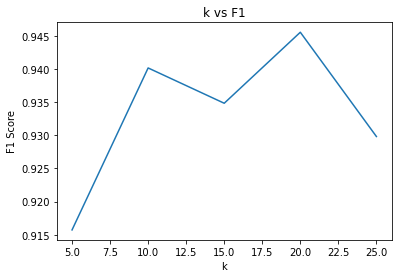

In [27]:
plotF1vsk()

In [28]:
#for k = 20
#Training and testing
categorical_cols =  ["Gender", "Marital_Status" , "Income_Category", "Education_Level", "Card_Category"]
numerical_cols = []
for e in df.columns:
  if e not in categorical_cols and e != 'Attrition_Flag' :
    numerical_cols.append(e)
catDict = dict()
numDict = dict()
N = df.shape[1]-1

alpha=1
for cat_col in categorical_cols:
  catDict[cat_col] = estimate_categorical(df,df[cat_col],alpha,N)

k=20
for num_col in numerical_cols:
  numDict[num_col] = estimate_numerical(df,df[num_col],1,N,k)

res=[]
for i in range(test_df.shape[0]):
  d=dict(test_df.iloc[i])
  label=d.pop('Attrition_Flag')
  X=d
  res.append([predict(X,train_df),label])
print(confusionMatrix(res))

[[165  14]
 [  5  19]]


#SVM

##Label encoding

In [29]:
transformed_df = df.copy()
def LabelEncoding(df,col):
  if col=='Attrition_Flag':
    for i in range(df.shape[0]):
      if df[col][i] == 'Existing Customer':
        df[col][i] = 1
      else: df[col][i] = -1
  else:
    s = list(df[col].unique())
    mapping={}
    for i in range(len(s)):
     mapping[s[i]] = i

    for k in range(df.shape[0]):
      df[col][k] = mapping[df[col][k]]

In [30]:
for col in categorical_cols:
 LabelEncoding(transformed_df,col)
LabelEncoding(transformed_df,"Attrition_Flag")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [31]:
N=transformed_df.shape[0]

##One hot encoding

##Quadratic optimization solving using CVXOPT or quadprog solvers

In [12]:
import numpy as np 
#creating X
X=transformed_df.values
N=X.shape[0]
#creating y
y=transformed_df["Attrition_Flag"].values

#creating P
yX=X.copy()
for i in range(N):
  yX[i] = y[i]*X[i]
yX_t=np.transpose(X)
P = -1*np.matmul(yX,yX_t)

#craeting q
q=np.transpose(np.array([1 for i in range(N)]))

#creating G
G=-1*np.identity(N)

#creating h
h=np.transpose(np.array([0 for i in range(N)]))

#creating A
A=y

#creating b
b=0

In [13]:
!pip install cvxopt

In [14]:
def cvxopt_solve_qp(P, q, G=None, h=None, A=None, b=None):
    P = .5 * (P + P.T)  # make sure P is symmetric
    args = [cvxopt.matrix(P), cvxopt.matrix(q)]
    if G is not None:
        args.extend([cvxopt.matrix(G), cvxopt.matrix(h)])
        if A is not None:
            args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return numpy.array(sol['x']).reshape((P.shape[1],))

In [ ]:
alphas=cvxopt_solve_qp(P,q,G,h,A,b) #not working